In [1]:
import os
from pathlib import Path
import requests
import zipfile
from PIL import Image
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    get_ipython().system('pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118')
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    get_ipython().system('pip install -q torchinfo')
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    get_ipython().system('git clone https://github.com/mrdbourke/pytorch-deep-learning')
    get_ipython().system('mv pytorch-deep-learning/going_modular .')
    get_ipython().system('mv pytorch-deep-learning/helper_functions.py .')
    get_ipython().system('rm -rf pytorch-deep-learning')
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Download and setup data
def download_data(source: str, destination: str):
    dest_path = Path(destination)
    if not dest_path.exists():
        dest_path.mkdir(parents=True, exist_ok=True)
    file_name = source.split('/')[-1]
    file_path = dest_path / file_name
    with open(file_path, "wb") as f:
        request = requests.get(source)
        print(f"Downloading {file_name}...")
        f.write(request.content)
    with zipfile.ZipFile(file_path, "r") as zip_ref:
        print(f"Extracting {file_name}...")
        zip_ref.extractall(dest_path)
    return dest_path

if os.path.exists("/kaggle/input/tiny-imagenet-200"):
    print("Detected Kaggle environment. Using Tiny ImageNet dataset from /kaggle/input/tiny-imagenet-200")
    image_path = Path("/kaggle/input/tiny-imagenet-200")
else:
    print("Kaggle dataset not found. Downloading Tiny ImageNet dataset.")
    image_path = download_data(source="https://cs231n.stanford.edu/tiny-imagenet-200.zip",
                               destination="tiny_imagenet")
    extracted_dir = image_path / "tiny-imagenet-200"
    if extracted_dir.exists():
        image_path = extracted_dir

train_dir = image_path / "train"
test_dir = image_path / "val"
print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124
[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1457), reused 1399 (delta 1399), pack-reused 2861 (from 3)
Receiving objects: 100% (4393/4393), 649.93 MiB | 32.63 MiB/s, done.
Resolving deltas: 100% (2660/2660), done.
Updating files: 100% (248/248), done.
Using device: cuda
Kaggle dataset not found. Downloading Tiny ImageNet dataset.
Extracting tiny-imagenet-200.zip...
Train directory: tiny_imagenet/tiny-imagenet-200/train
Test directory: tiny_imagenet/tiny-imagenet-200/val


In [3]:
# Define transforms
IMG_SIZE = 128
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [4]:
from torch.utils.data import Dataset
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, annotation_file, class_to_idx, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.annotations = self._load_annotations(annotation_file)
        self.class_to_idx = class_to_idx

    def _load_annotations(self, annotation_file):
        annotations = {}
        with open(annotation_file, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')  # Explicitly split on tabs
                img_name = parts[0]              # Image filename
                class_name = parts[1]            # Class label
                annotations[img_name] = class_name
        return annotations

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = list(self.annotations.keys())[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.annotations[img_name]
        label_idx = self.class_to_idx[label]
        if self.transform:
            image = self.transform(image)
        return image, label_idx

In [5]:
# Create data loaders
BATCH_SIZE = 16
train_dataset = datasets.ImageFolder(root=train_dir, transform=manual_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
class_to_idx = train_dataset.class_to_idx
class_names = train_dataset.classes
test_img_dir = test_dir / "images"
test_annotation_file = test_dir / "val_annotations.txt"

test_dataset = CustomImageDataset(
    img_dir=test_img_dir,
    annotation_file=test_annotation_file,
    class_to_idx=class_to_idx,
    transform=manual_transforms
)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_dataset = CustomImageDataset(img_dir=test_img_dir, annotation_file=test_annotation_file, class_to_idx=class_to_idx, transform=manual_transforms)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

subset_size = 5000 # Desired size for training and testing

train_dataset_subset = torch.utils.data.Subset(train_dataset, range(subset_size))
test_dataset_subset = torch.utils.data.Subset(test_dataset, range(subset_size))

train_dataloader = DataLoader(train_dataset_subset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset_subset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Train dataset size: {len(train_dataset_subset)}")
print(f"Test dataset size: {len(test_dataset_subset)}")

Train dataset size: 5000
Test dataset size: 5000


# ------------------------
# Visualize a Sample Image
# ------------------------

Image shape: torch.Size([3, 128, 128]) Label: tensor(0)


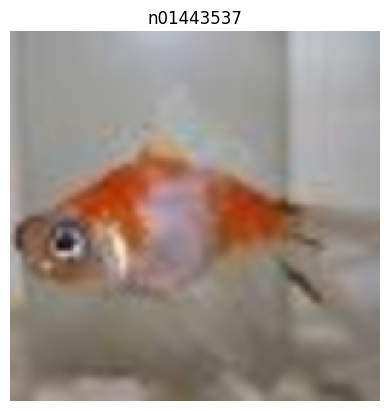

In [6]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
print("Image shape:", image.shape, "Label:", label)
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

Number of patches (N) with image height (H=128), width (W=128) and patch size (P=16): 64
Input shape (single 2D image): (128, 128, 3)
Output shape (single 2D image flattened into patches): (64, 768)


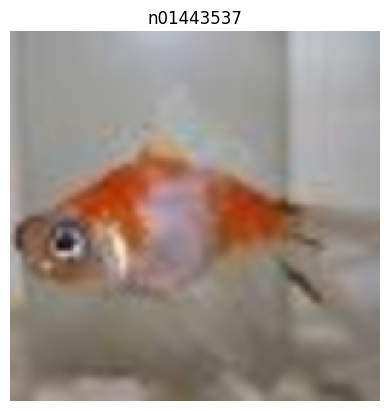

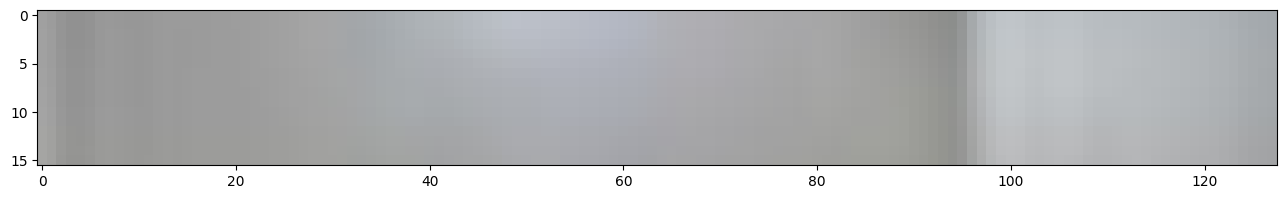

Number of patches per row: 8.0
Patch size: 16 pixels x 16 pixels
Number of patches per row: 8.0        
Number of patches per column: 8.0        
Total patches: 64.0        
Patch size: 16 pixels x 16 pixels


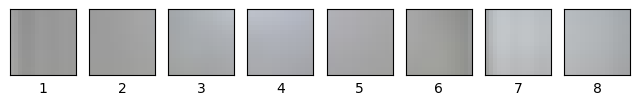

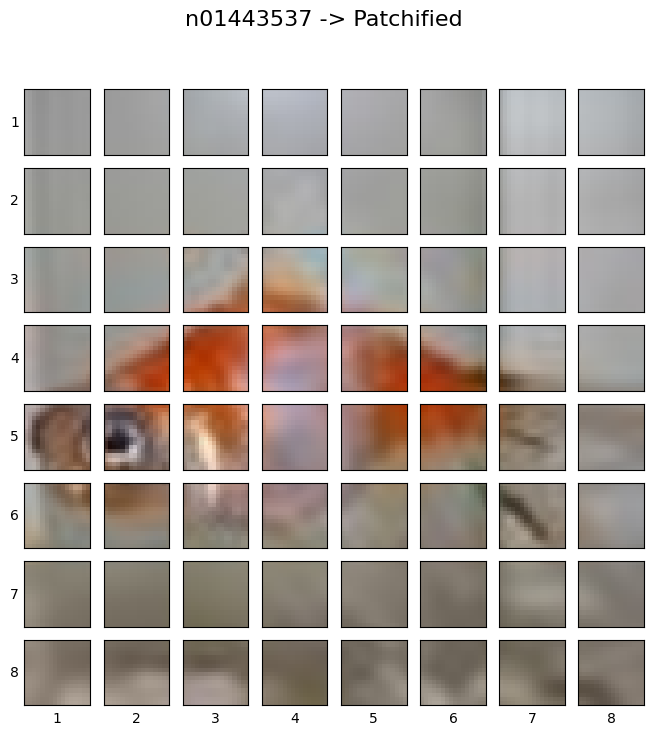

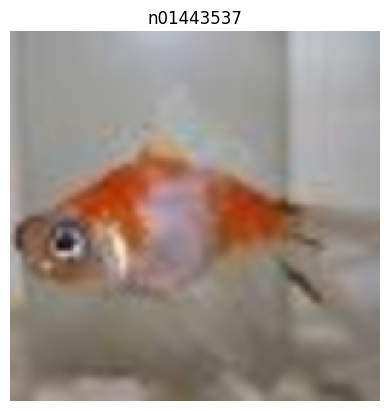

Conv output shape: torch.Size([1, 768, 8, 8])
Showing random convolutional feature maps from indexes: [414, 245, 57, 757, 396]


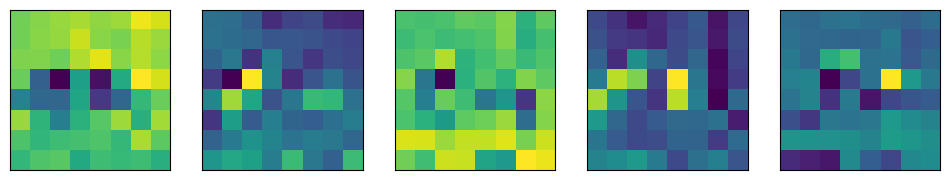

Single feature map tensor: tensor([[[ 0.0304,  0.0362,  0.0368,  0.0337,  0.0400,  0.0401,  0.0654,
           0.0455],
         [ 0.0221,  0.0340,  0.0299,  0.0461,  0.0355,  0.0401,  0.0587,
           0.0329],
         [ 0.0133,  0.0341,  0.1372,  0.0085,  0.0514,  0.0659,  0.0673,
           0.0398],
         [ 0.0226,  0.1680,  0.0906,  0.1535,  0.1731,  0.0874,  0.0234,
           0.0278],
         [ 0.0211,  0.1303,  0.1829,  0.0376,  0.0926,  0.1407,  0.0484,
           0.0543],
         [-0.0220,  0.1062,  0.0614,  0.0429,  0.0867,  0.0616,  0.0659,
           0.0477],
         [ 0.0405,  0.0297,  0.0256,  0.0359,  0.0425,  0.0465,  0.0507,
           0.0289],
         [ 0.0019,  0.0148,  0.0613,  0.0415,  0.0281, -0.0056,  0.0747,
           0.0114]]], grad_fn=<SliceBackward0>) True
Current tensor shape: torch.Size([1, 768, 8, 8]) -> [batch, embedding_dim, feature_map_height, feature_map_width]
Original image shape: torch.Size([3, 128, 128])
Image feature map shape: torch.Siz

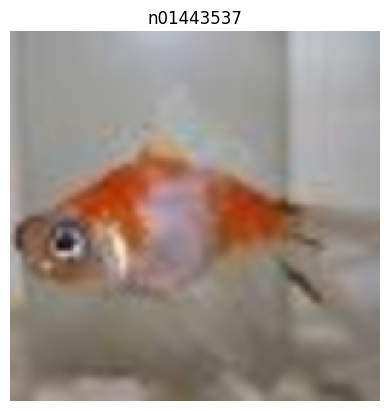

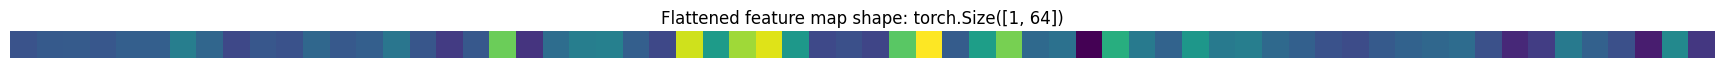

In [7]:
height = 128
width = 128
color_channels = 3
patch_size = 16
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

image_permuted = image.permute(1, 2, 0)
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])
plt.show()

img_size = 128
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

img_size = 128
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size,
                                        :])
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

# ------------------------------
# Convolutional Patch Embedding
# ------------------------------
patch_size = 16
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

image_out_of_conv = conv2d(image.unsqueeze(0))
print("Conv output shape:", image_out_of_conv.shape)

import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
plt.show()

single_feature_map = image_out_of_conv[:, 0, :, :]
print("Single feature map tensor:", single_feature_map, single_feature_map.requires_grad)
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

flatten = nn.Flatten(start_dim=2, end_dim=3)
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)
plt.show()

In [8]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)

set_seeds()
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
print("Class token (first 10 values):", class_token[:, :, :10])
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

number_of_patches = int((height * width) / patch_size**2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)
print("Position embedding (first 10x10 values):", position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Input image shape: torch.Size([1, 3, 128, 128])
Output patch embedding shape: torch.Size([1, 64, 768])
tensor([[[-0.6116,  0.1684, -0.1742,  ...,  0.4650, -0.2959,  0.2181],
         [-0.6655,  0.1855, -0.1839,  ...,  0.4992, -0.2975,  0.2201],
         [-0.7174,  0.2117, -0.1784,  ...,  0.5304, -0.3289,  0.2362],
         ...,
         [-0.4616,  0.0844, -0.2085,  ...,  0.3710, -0.2036,  0.2244],
         [-0.4302,  0.0974, -0.1835,  ...,  0.2842, -0.1960,  0.2505],
         [-0.5470,  0.1498, -0.1000,  ...,  0.3760, -0.2331,  0.1188]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 64, 768]) -> [batch_size, number_of_patches, embedding_dimension]
Class token (first 10 values): tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.6116,  0.1684, -0.1742, 

In [9]:
set_seeds()
patch_size = 16
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")
patch_embedding_layer = PatchEmbedding(in_channels=3, patch_size=patch_size, embedding_dim=768)
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 128, 128])
Input image with batch dimension shape: torch.Size([1, 3, 128, 128])
Patching embedding shape: torch.Size([1, 64, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 65, 768])
Patch and position embedding shape: torch.Size([1, 65, 768])


In [10]:
# -------------------------
# Multihead Self-Attention Block
# -------------------------
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short)."""
    def __init__(self, embedding_dim: int = 768, num_heads: int = 12, attn_dropout: float = 0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        return attn_output

multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, num_heads=12)
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 65, 768])
Output shape MSA block: torch.Size([1, 65, 768])


In [11]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    def __init__(self, embedding_dim: int = 768, mlp_size: int = 3072, dropout: float = 0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

mlp_block = MLPBlock(embedding_dim=768, mlp_size=3072, dropout=0.1)
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 65, 768])
Output shape MLP block: torch.Size([1, 65, 768])


In [12]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    def __init__(self, embedding_dim: int = 768, num_heads: int = 12, mlp_size: int = 3072, mlp_dropout: float = 0.1, attn_dropout: float = 0):
        super().__init__()
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout)
    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

transformer_encoder_block = TransformerEncoderBlock()

torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, nhead=12, dim_feedforward=3072, dropout=0.1, activation="gelu", batch_first=True, norm_first=True)
print(torch_transformer_encoder_layer)

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)


Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([16, 1, 768])
tensor([[ 0.9653, -0.4275,  0.4591, -1.2064, -0.9844,  0.1421, -0.2171,  0.3610,
         -0.0107,  0.2108,  0.4755, -1.1338,  0.3543, -0.2372, -0.1010, -0.2937,
         -0.6300, -0.1929,  0.6654,  0.9199,  0.1955, -0.4875,  0.5436,  0.0390,
          0.2722, -0.4865, -0.1933,  0.2392,  0.4400,  0.5519, -0.6899,  0.1354,
          0.2269, -0.3380,  1.0479, -0.4384,  0.5165, -0.3713,  0.3609, -0.8150,
          0.7740, -0.0986, -0.5338,  0.3246, -0.2431,  0.2896,  0.8123,  0.5320,
          0.3214, -0.1094,  0.3908,  0.3474,  0.0828,  0.1787,  0.5287,  0.8340,
         -0.3433, -0.2685, -0.1295, -0.4600,  0.1210,  0.4116, -0.1858,  0.1214,
         -0.6823,  0.1201,  0.4104, -0.3895,  0.0566, -0.6412, -0.3078,  0.0975,
         -0.4553,  0.0907,  1.1141, -0.5600,  0.0602, -0.7661, -0.3085,  0.7616,
          0.5208,  0.5825, -0.7786, -0.5668, -1.0373,  0.7503

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1886 | train_acc: 0.0190 | test_loss: 5.3152 | test_acc: 0.0040
Epoch: 2 | train_loss: 5.1426 | train_acc: 0.0917 | test_loss: 5.2997 | test_acc: 0.0062
Epoch: 3 | train_loss: 5.1316 | train_acc: 0.0978 | test_loss: 5.2994 | test_acc: 0.0048
Epoch: 4 | train_loss: 5.1071 | train_acc: 0.1040 | test_loss: 5.3011 | test_acc: 0.0040
Epoch: 5 | train_loss: 4.9640 | train_acc: 0.0964 | test_loss: 5.3180 | test_acc: 0.0062
Epoch: 6 | train_loss: 4.7904 | train_acc: 0.1010 | test_loss: 5.3332 | test_acc: 0.0062
Epoch: 7 | train_loss: 4.7682 | train_acc: 0.0998 | test_loss: 5.3325 | test_acc: 0.0062
Epoch: 8 | train_loss: 4.7624 | train_acc: 0.0998 | test_loss: 5.3326 | test_acc: 0.0062
Epoch: 9 | train_loss: 4.7584 | train_acc: 0.1006 | test_loss: 5.3390 | test_acc: 0.0062
Epoch: 10 | train_loss: 4.7583 | train_acc: 0.0996 | test_loss: 5.3375 | test_acc: 0.0062
2.5.1+cu124
0.20.1+cu124
Using device: cuda


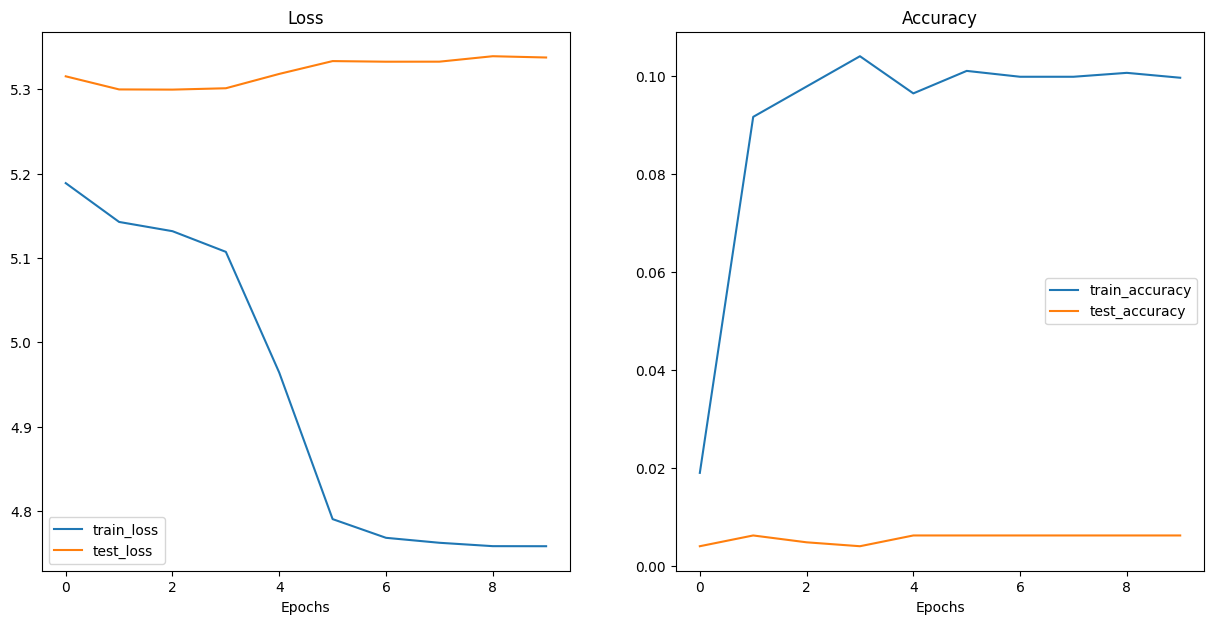

In [13]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    def __init__(self, img_size: int = 128, in_channels: int = 3, patch_size: int = 16, num_transformer_layers: int = 12, embedding_dim: int = 768, mlp_size: int = 3072, num_heads: int = 12, attn_dropout: float = 0, mlp_dropout: float = 0.1, embedding_dropout: float = 0.1, num_classes: int = 1000):
        super().__init__()
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        self.num_patches = (img_size * img_size) // patch_size**2
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim, num_heads=num_heads, mlp_size=mlp_size, mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )
    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x

batch_size = 16
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768))
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

set_seeds()
random_image_tensor = torch.randn(1, 3, 128, 128)
vit = ViT(num_classes=len(class_names))
print(vit(random_image_tensor))

from torchinfo import summary
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

from torch.amp import GradScaler, autocast
scalar = GradScaler('cuda')
with autocast('cuda') :
  results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)


from helper_functions import plot_loss_curves
plot_loss_curves(results)

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)